<a href="https://colab.research.google.com/github/akhundMurad/TextualMoodRecognition/blob/development/MoodRecognitionTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mood Recognition
This work represents my first attempt to solve a mood recognition task using the Deep Learning technique.


## Context
1. Dataset preparation.<br>
    1.1. Load dataset.<br>
    1.2. Data vectorization.<br>
    1.3. Applying one-hot encoding.<br>
2. Building model architecture.<br>
    2.1. Initial architecture.<br>
    2.2. Hyperparameters.<br>
    2.3. Regularization methods.<br>
3. Results and metrics of training.


## 1. Dataset preparation.
We decided to train our model basing on the ["Emotion Dataset for Emotion Recognition Tasks"](https://www.kaggle.com/datasets/parulpandey/emotion-dataset) dataset.

**Original description:**

A dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise.

The authors constructed a set of hashtags to collect a separate dataset of English tweets from the Twitter API belonging to eight basic emotions, including anger, anticipation, disgust, fear, joy, sadness, surprise, and trust. The data has already been preprocessed based on the approach described in their paper.

**Example:**

```json
{
   "label": 0,
   "text": "im feeling quite sad and sorry for myself but ill snap out of it soon"
}
```

#### 1.1. Load dataset.

In [1]:
import pandas as pd

test_dataframe = pd.read_csv("data/test.csv")
train_dataframe = pd.read_csv("data/training.csv")
val_dataframe = pd.read_csv("data/validation.csv")

test_data, test_labels = test_dataframe["text"], test_dataframe["label"]
train_data, train_labels = train_dataframe["text"], train_dataframe["label"]
val_data, val_labels = val_dataframe["text"], val_dataframe["label"]

print(test_data.shape, test_labels.shape)

(2000,) (2000,)


#### 1.2. Data vectorization.

Here, we apply one-hot encoding to convert textual data into binary vectors. This conversion optimizes computer computations.

In [4]:
import numpy as np
import tensorflow as tf


def vectorize_text_series(series: pd.Series):
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=8000, output_mode="multi_hot", pad_to_max_tokens=True
    )
    text_vectorizer.adapt(series)
    return text_vectorizer(series), text_vectorizer


x_test, test_text_vectorizer = vectorize_text_series(test_data)
x_train, train_text_vectorizer = vectorize_text_series(train_data)
x_val, val_text_vectorizer = vectorize_text_series(val_data)

print("Vectorized text shape: ", x_test.shape)
print("Example: ", end="\n")
print(x_test[0])

Vectorized text shape:  (2000, 8000)
Example: 
tf.Tensor([0. 0. 0. ... 0. 0. 0.], shape=(8000,), dtype=float32)


#### 1.3. Applying one-hot encoding
One-hot encoding simply converts categorical data into binary vectors so that each "column" represents one category.

In [5]:
x_test_one_hot = pd.get_dummies(test_dataframe["label"], dtype="float32")
x_train_one_hot = pd.get_dummies(train_dataframe["label"], dtype="float32")
x_val_one_hot = pd.get_dummies(val_dataframe["label"], dtype="float32")

y_test = tf.convert_to_tensor(x_test_one_hot)
y_train = tf.convert_to_tensor(x_train_one_hot)
y_val = tf.convert_to_tensor(x_val_one_hot)

## 2. Building model architecture.
In order to have an optimized and generalized model, engineers the diversity of architectures. Each architecture has its own set of hyperparameters, which may affect the model's accuracy and loss.

This section will begin with the simplest (initial) architecture. Step-by-step, the model will be adjusted to get more accurate results on the validation and training sets. Our goal is to get a model with at least an accuracy of 30%.

#### 2.1. Ininitial architecture.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers


# Using Keras Functional API.
inputs = keras.Input(shape=(x_train.shape[1],), name="input_text")
features = layers.Dense(units=64, activation="relu", name="features")(inputs)
outputs = layers.Dense(units=y_train.shape[1], activation="softmax", name="output_mood")(features)

In [7]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_text (InputLayer)     [(None, 8000)]            0         
                                                                 
 features (Dense)            (None, 64)                512064    
                                                                 
 output_mood (Dense)         (None, 6)                 390       
                                                                 
Total params: 512454 (1.95 MB)
Trainable params: 512454 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    batch_size=512,
    validation_data=[x_val, y_val],
    verbose=0,
)

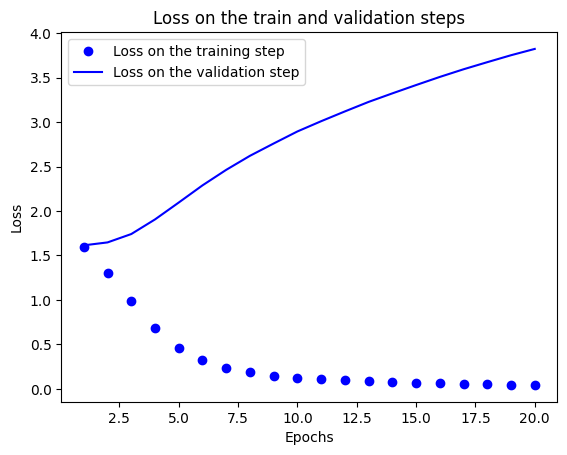

In [10]:
import matplotlib.pyplot as plt

def show_history_plot(history_dict: dict):
    plt.close()

    loss_values = history_dict["loss"]
    validation_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, "bo", label="Loss on the training step")
    plt.plot(epochs, validation_loss_values, "b", label="Loss on the validation step")
    plt.title("Loss on the train and validation steps")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


show_history_plot(history.history)

This line chart demonstrates the results of the loss function on each iteration (epoch).
At this point, our model will predict correct results almost always. However, this is true only for training data. Let's try to generalize it.

#### 2.2. Hyperparameters.
In this section, we will adjust the learning rate, batch size, and epoch count.

In [11]:
inputs = keras.Input(shape=(x_train.shape[1],), name="input_text")
features = layers.Dense(units=16, activation="relu")(inputs)
features = layers.Dense(units=16, activation="relu")(features)
outputs = layers.Dense(units=y_train.shape[1], activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
opt = keras.optimizers.Adam(1e-5)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    batch_size=32,
    validation_data=[x_val, y_val],
)

Epoch 1/20
500/500 [==============================] - 3s 3ms/step - loss: 1.7851 - accuracy: 0.1863 - val_loss: 1.7808 - val_accuracy: 0.2000
Epoch 2/20
500/500 [==============================] - 1s 3ms/step - loss: 1.7742 - accuracy: 0.2163 - val_loss: 1.7706 - val_accuracy: 0.2130
Epoch 3/20
500/500 [==============================] - 1s 3ms/step - loss: 1.7601 - accuracy: 0.2421 - val_loss: 1.7578 - val_accuracy: 0.2300
Epoch 4/20
500/500 [==============================] - 1s 3ms/step - loss: 1.7435 - accuracy: 0.2674 - val_loss: 1.7437 - val_accuracy: 0.2490
Epoch 5/20
500/500 [==============================] - 2s 3ms/step - loss: 1.7252 - accuracy: 0.3056 - val_loss: 1.7287 - val_accuracy: 0.2805
Epoch 6/20
500/500 [==============================] - 2s 3ms/step - loss: 1.7055 - accuracy: 0.3373 - val_loss: 1.7129 - val_accuracy: 0.3180
Epoch 7/20
500/500 [==============================] - 1s 3ms/step - loss: 1.6849 - accuracy: 0.3548 - val_loss: 1.6969 - val_accuracy: 0.3435
Epoch 

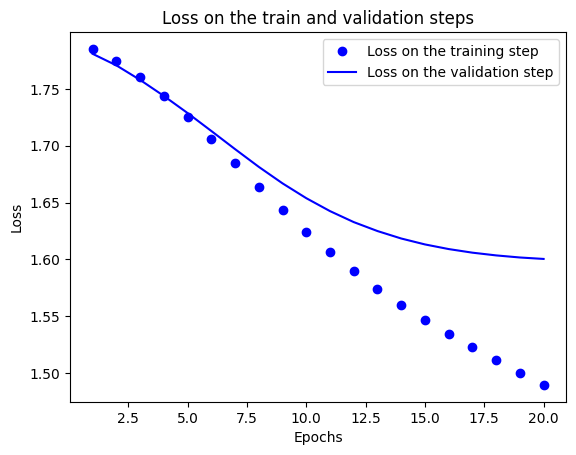

In [13]:
show_history_plot(history.history)

#### 2.3. Regularization methods.
Let's try to add some regularization methods.

The lack of generalization is caused by the fact that at some point in the learning process, the optimizer tunes weights to the training dataset (overfitting). As if, it says: "Why I need to calculate all this math stuff, if I can just remember the answers?". To prevent overfitting from happening, we can implement several methods, including:
1. Dropout.
2. Regularization.

Let's start with the first one:

**Dropout** technique "drops out" weights of the network with predefined probability. If the network cannot remember answers, it is forced to compute.

In [14]:
inputs = keras.Input(shape=(x_train.shape[1],), name="input_text")
features = layers.Dense(units=16, activation="relu")(inputs)
dropout = layers.Dropout(0.5)(features)
features = layers.Dense(units=16, activation="relu")(dropout)
dropout = layers.Dropout(0.5)(features)
outputs = layers.Dense(units=y_train.shape[1], activation="softmax")(dropout)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
opt = keras.optimizers.Adam(1e-5)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=40,
    batch_size=32,
    validation_data=[x_val, y_val],
    verbose=0,
)

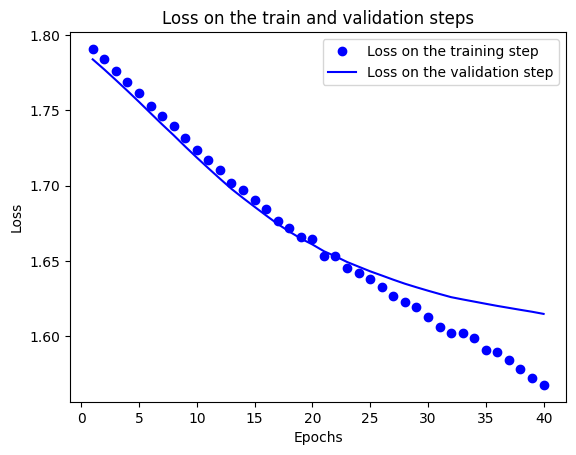

In [16]:
show_history_plot(history.history)

As a result, the validation process became closer to training.

**L2 Regularization**

Regularization adds a calculated penalty to the result of the loss function. Consequently, the optimizer becomes more limited in terms of weight modification.



In [17]:
inputs = keras.Input(shape=(x_train.shape[1],), name="input_text")
features = layers.Dense(units=16, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(inputs)
features = layers.Dropout(0.5)(features)
features = layers.Dense(units=16, activation="relu")(features)
features = layers.Dropout(0.5)(features)
features = layers.Dense(units=16, activation="relu")(features)
features = layers.Dropout(0.5)(features)
features = layers.Dense(units=16, activation="relu")(features)
features = layers.Dropout(0.5)(features)
features = layers.Dense(units=64, activation="relu")(features)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(units=y_train.shape[1], activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
opt = keras.optimizers.Adam(1e-5)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=40,
    batch_size=32,
    validation_data=[x_val, y_val],
    verbose=0,
)

## 3. Results and metrics of training.

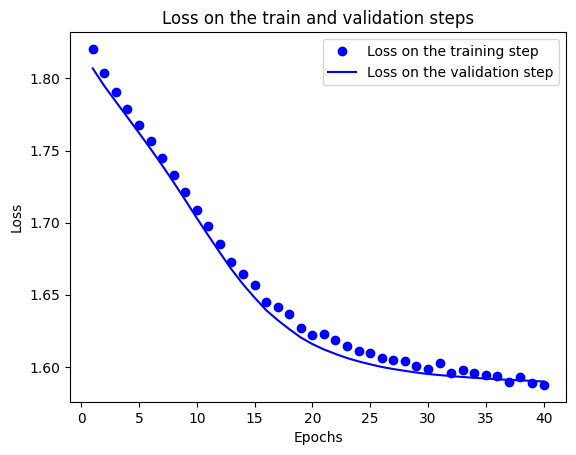

In [20]:
plt.close()

loss_values = history.history["loss"]
validation_loss_values = history.history["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Loss on the training step")
plt.plot(epochs, validation_loss_values, "b", label="Loss on the validation step")
plt.title("Loss on the train and validation steps")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


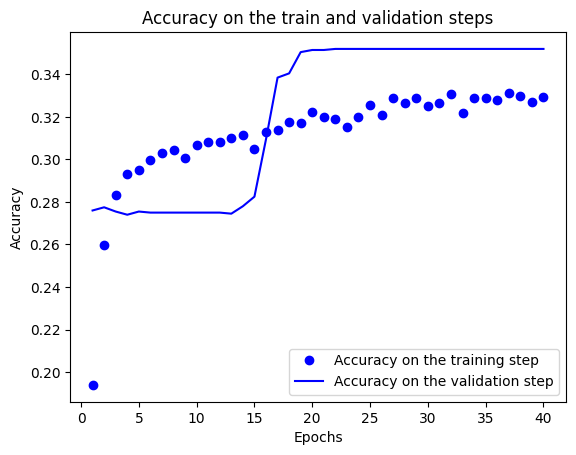

In [21]:
plt.close()

acc_values = history.history["accuracy"]
validation_acc_values = history.history["val_accuracy"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, "bo", label="Accuracy on the training step")
plt.plot(epochs, validation_acc_values, "b", label="Accuracy on the validation step")
plt.title("Accuracy on the train and validation steps")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


The model reached a maximum of 35% accuracy.

Indeed, it is not the total capacity of deep learning, and we can prepare a more optimized and generalized model.